In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
data = pd.read_csv('data.txt', sep=';', skiprows=2)

In [3]:
data.drop('Unnamed: 10', axis = 1, inplace = True)

In [4]:
data.loc[:, 'Datum'] = pd.to_datetime(data['Datum'], format='%d.%m.%Y %H:%M')

In [5]:
bool_series = data['Datum'].duplicated() 

In [6]:
data.drop([7202], axis = 0, inplace = True)

In [7]:
data.reset_index(drop=True, inplace = True)

In [8]:
data['ZE [MW]'] = data['ZE [MW]'].astype(float)

In [9]:
df_for_prediction = data
columns_to_sum = ['PE [MW]', 'PPE [MW]', 'JE [MW]', 'VE [MW]', 'PVE [MW]', 'AE [MW]', 'ZE [MW]', 'VTE [MW]', 'FVE [MW]']
df_for_prediction['sum_of_consumptions'] = df_for_prediction[columns_to_sum].sum(axis = 1)
df_for_prediction.drop(columns_to_sum, axis = 1, inplace = True)

In [10]:
df_for_prediction.sort_values(by='Datum', inplace=True, ascending=True)

In [11]:
df_for_prediction = df_for_prediction.groupby(pd.to_datetime(df_for_prediction.Datum).dt.date).agg({'sum_of_consumptions': 'sum'}).reset_index() 

In [12]:
df_for_prediction.set_index('Datum', inplace=True)

In [13]:
df_for_prediction.drop(df_for_prediction.index[0], inplace = True)
df_for_prediction.drop(df_for_prediction.index[-1], inplace = True)

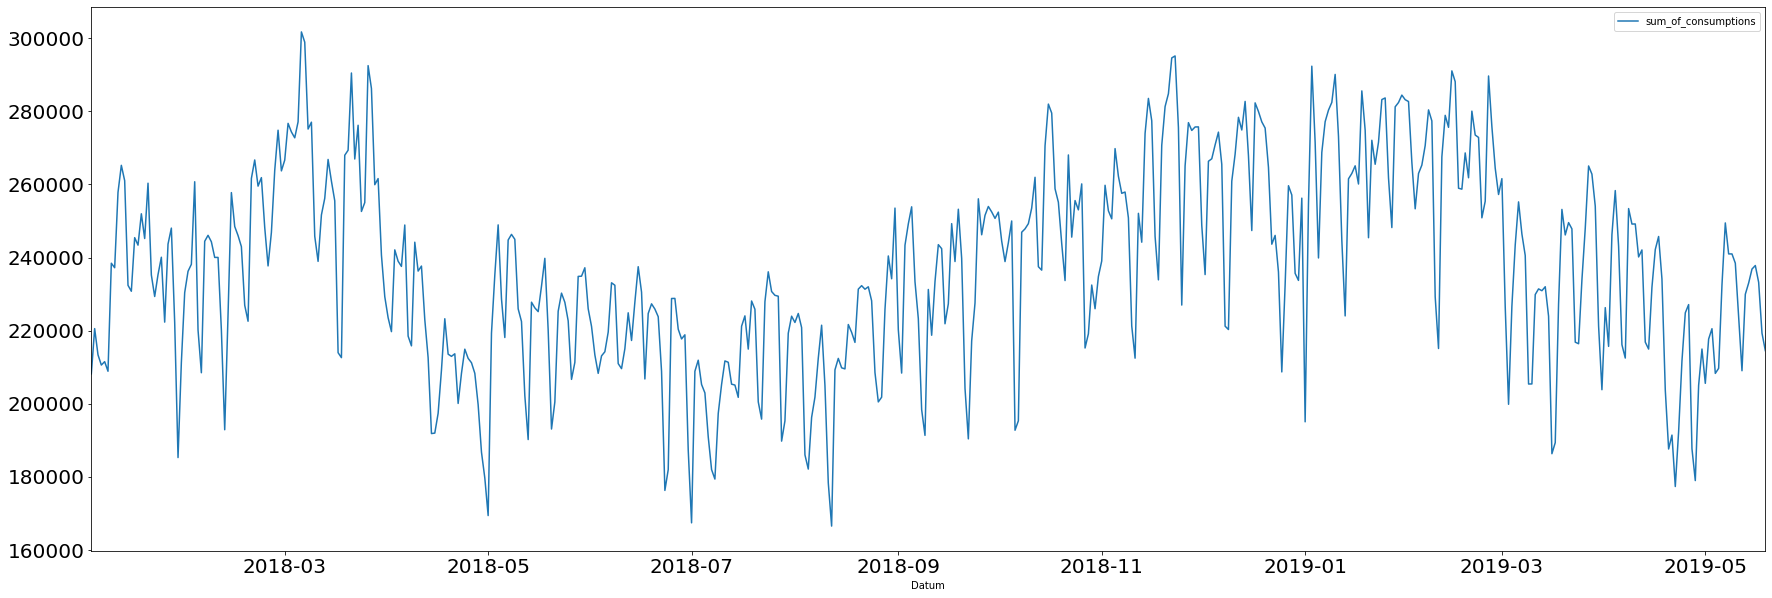

In [14]:
#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import cufflinks as cf
#init_notebook_mode(connected=True)
#cf.go_offline()

#df_for_prediction.plot(title="Energy Consumption")
df_for_prediction.plot(figsize = (30,10), fontsize = 20, legend = True)

In [15]:
df_for_prediction

,sum_of_consumptions
Datum,
2018-01-02,208199.8
2018-01-03,220569.4
2018-01-04,213397.9
2018-01-05,210597.5
2018-01-06,211530.2
...,...
2019-05-15,236852.9
2019-05-16,237815.1
2019-05-17,233224.2


C:\Users\Denys\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

the 'freq' keyword is deprecated, use 'period' instead



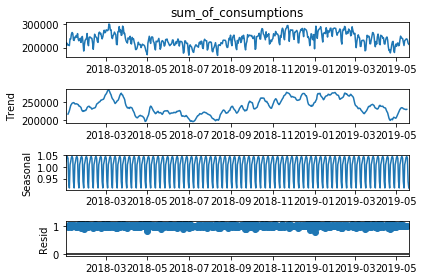

In [16]:
from plotly.offline import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

#layout1 = cf.Layout(height=300,width=200)

result = seasonal_decompose(df_for_prediction['sum_of_consumptions'], model='multiplicative', freq = 7)
fig = result.plot()
#plot_mpl(fig)

In [17]:
df_for_prediction.index = pd.DatetimeIndex(df_for_prediction.index).to_period('D')

In [18]:
from pmdarima import auto_arima
#print(pyramid.__version__)

model = auto_arima(df_for_prediction, start_p=0, start_q=0,
                           max_p=10, max_q=10, m=7,
                           start_P=0, start_Q = 0, max_P = 10, max_Q = 10, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=True]; AIC=11700.649, BIC=11709.090, Time=0.032 seconds
Fit ARIMA(1,0,0)x(1,0,0,7) [intercept=True]; AIC=11108.051, BIC=11124.933, Time=0.440 seconds
Fit ARIMA(0,0,1)x(0,0,1,7) [intercept=True]; AIC=11369.527, BIC=11386.410, Time=0.129 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=False]; AIC=13885.828, BIC=13890.048, Time=0.008 seconds
Fit ARIMA(1,0,0)x(0,0,0,7) [intercept=True]; AIC=11233.372, BIC=11246.034, Time=0.033 seconds
Fit ARIMA(1,0,0)x(2,0,0,7) [intercept=True]; AIC=11096.493, BIC=11117.596, Time=4.397 seconds
Fit ARIMA(1,0,0)x(3,0,0,7) [intercept=True]; AIC=11093.588, BIC=11118.911, Time=15.755 seconds
Fit ARIMA(1,0,0)x(4,0,0,7) [intercept=True]; AIC=11098.056, BIC=11127.600, Time=31.628 seconds
Fit ARIMA(1,0,0)x(3,0,1,7) [intercept=True]; AIC=11066.752, BIC=11096.296, Time=5.117 seconds
Fit ARIMA(1,0,0)x(2,0,1,7) [intercept=True]; AIC=11101.749, BIC=11127.072, Time=2.450 seconds
Fit ARIMA(1,0,

In [19]:
train = df_for_prediction.iloc[:489]
test = df_for_prediction.iloc[489:]

In [20]:
train

,sum_of_consumptions
Datum,
2018-01-02,208199.8
2018-01-03,220569.4
2018-01-04,213397.9
2018-01-05,210597.5
2018-01-06,211530.2
...,...
2019-05-01,205598.9
2019-05-02,217718.3
2019-05-03,220542.7


In [21]:
test

,sum_of_consumptions
Datum,
2019-05-06,232507.2
2019-05-07,249467.8
2019-05-08,240993.3
2019-05-09,240987.4
2019-05-10,238462.7
2019-05-11,223843.1
2019-05-12,209043.4
2019-05-13,229958.2
2019-05-14,233038.2


In [22]:
model.fit(train)

ARIMA(order=(2, 0, 1), seasonal_order=(3, 0, 1, 7), suppress_warnings=True)

In [23]:
future_forecast, conf_int = model.predict(n_periods=14, return_conf_int=True, alpha=0.05)
#print(conf_int)
#print(future_forecast)

In [24]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
future_forecast['lower_series'] = conf_int[:, 0]
future_forecast['upper_series'] = conf_int[:, 1]
future_forecast['real_values'] = test['sum_of_consumptions']
future_forecast

,Prediction,lower_series,upper_series,real_values
Datum,,,,
2019-05-06,217211.321455,184770.781877,249651.861032,232507.2
2019-05-07,224915.593245,185257.140958,264574.045531,249467.8
2019-05-08,225789.543999,183288.273371,268290.814627,240993.3
2019-05-09,229457.104602,185566.869046,273347.340158,240987.4
2019-05-10,223983.728308,179516.007659,268451.448958,238462.7
2019-05-11,210272.608234,165488.562287,255056.654181,223843.1
2019-05-12,209314.139380,164409.706959,254218.571801,209043.4
2019-05-13,213927.609943,167537.359017,260317.860870,229958.2
2019-05-14,220569.952084,173527.670943,267612.233225,233038.2


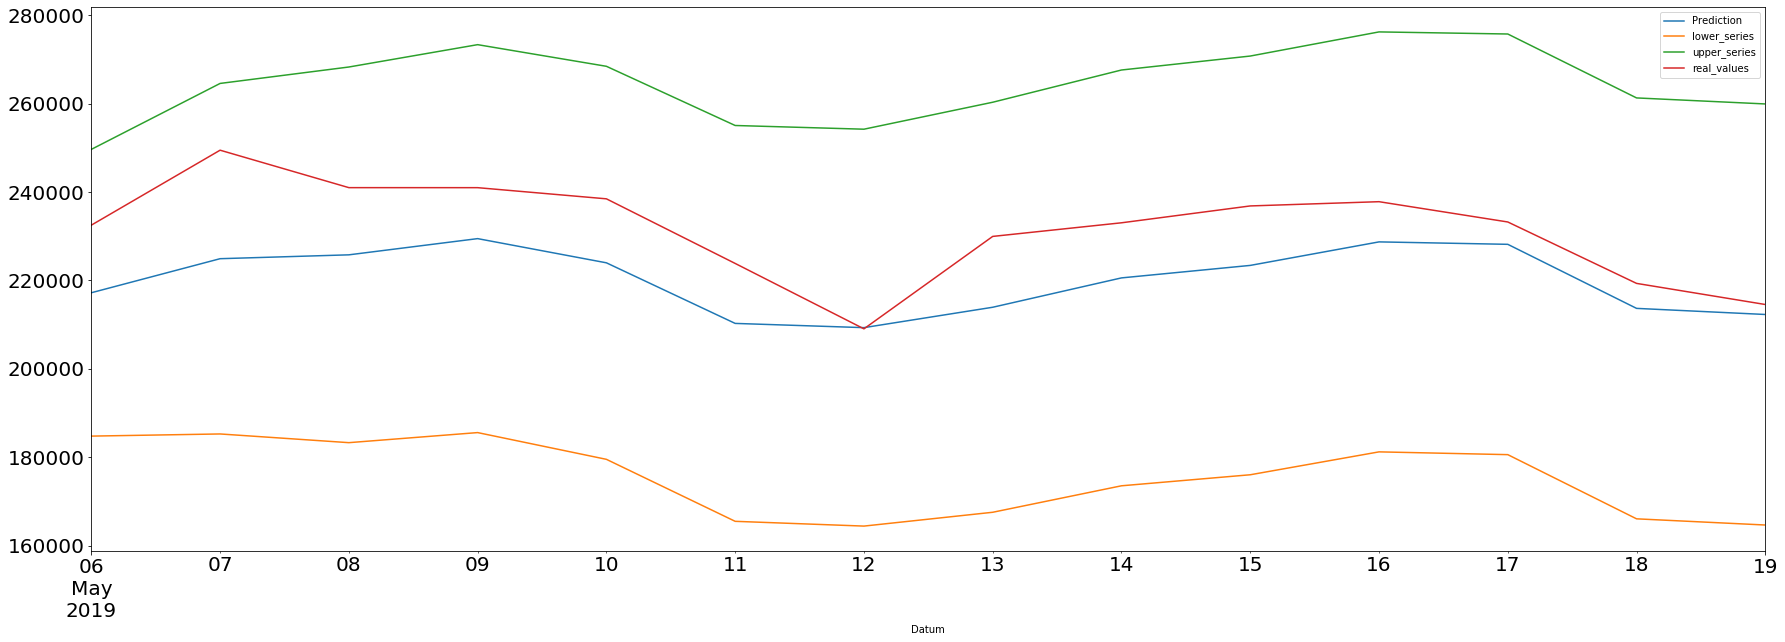

In [25]:
future_forecast.plot(figsize = (30,10), fontsize = 20)

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test, future_forecast['Prediction']))
rmse

12910.721153082333

In [27]:
mse = mean_squared_error(test, future_forecast['Prediction'])
mse

166686720.69264764